In [1]:
# Needed for AMD Strix Halo GPU to run on ROCM < 7.0.0
from os import putenv
putenv("HSA_OVERRIDE_GFX_VERSION", "11.0.0")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchtext import data, datasets as torchtext_datasets
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

np.random.seed(528)
torch.manual_seed(528)
if device.type == "cuda":
    torch.cuda.manual_seed_all(528)

Using device: cuda


/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


In [3]:
# all manually implemented optimizers, but only used for 6.1
class AdamOptimizer:
    def __init__(self, params, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.m = {k: np.zeros_like(v) for k,v in params.items()}
        self.v = {k: np.zeros_like(v) for k,v in params.items()}
        self.t = 0
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

    def step(self, params, grads):
        self.t += 1
        for k in params.keys():
            g = grads[k]
            self.m[k] = self.beta1 * self.m[k] + (1 - self.beta1) * g
            self.v[k] = self.beta2 * self.v[k] + (1 - self.beta2) * (g * g)
            m_hat = self.m[k] / (1 - (self.beta1 ** self.t))
            v_hat = self.v[k] / (1 - (self.beta2 ** self.t))
            params[k] -= self.alpha * m_hat / (np.sqrt(v_hat) + self.eps)

class SGDNesterovOptimizer:
    def __init__(self, params, alpha=0.05, momentum=0.9):
        self.v = {k: np.zeros_like(v) for k,v in params.items()}
        self.alpha = alpha
        self.momentum = momentum
        self.t = 0

    def step(self, params, grads):
        self.t += 1 # can be used to check number of steps
        for k in params.keys():
            self.v[k] = self.momentum * self.v[k] - self.alpha * grads[k]
            params[k] += self.v[k]

class AdaGradOptimizer:
    def __init__(self, params, alpha=0.05, eps=1e-10):
        self.alpha = alpha
        self.eps = eps
        self.G = {k: np.zeros_like(v) for k,v in params.items()}
        self.t = 0

    def step(self, params, grads):
        self.t += 1 # can be used to check number of steps
        for k in params.keys():
            g = grads[k]
            self.G[k] += g * g
            params[k] -= self.alpha * g / (np.sqrt(self.G[k]) + self.eps)

class RMSPropOptimizer:
    def __init__(self, params, alpha=0.001, beta=0.9, eps=1e-8):
        self.s = {k: np.zeros_like(v) for k, v in params.items()}
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
        self.t = 0

    def step(self, params, grads):
        self.t += 1
        for k in params.keys():
            g = grads[k]
            self.s[k] = self.beta * self.s[k] + (1.0 - self.beta) * (g * g)
            params[k] -= self.alpha * g / (np.sqrt(self.s[k]) + self.eps)

class AdaDeltaOptimizer:
    def __init__(self, params, rho=0.95, eps=1e-6):
        self.Eg2 = {k: np.zeros_like(v) for k, v in params.items()}
        self.Edx2 = {k: np.zeros_like(v) for k, v in params.items()}
        self.rho = rho
        self.eps = eps

    def step(self, params, grads):
        for k in params.keys():
            g = grads[k]
            self.Eg2[k] = self.rho * self.Eg2[k] + (1.0 - self.rho) * (g * g)
            # update
            rms_dx = np.sqrt(self.Edx2[k] + self.eps)
            rms_g  = np.sqrt(self.Eg2[k]  + self.eps)
            dx = - (rms_dx / rms_g) * g
            params[k] += dx
            self.Edx2[k] = self.rho * self.Edx2[k] + (1.0 - self.rho) * (dx * dx)

MNIST with AdaGrad | Epoch 1 | Cost 0.4040
MNIST with AdaGrad | Epoch 2 | Cost 0.3621
MNIST with AdaGrad | Epoch 3 | Cost 0.3430
MNIST with AdaGrad | Epoch 4 | Cost 0.3324
MNIST with AdaGrad | Epoch 5 | Cost 0.3244
MNIST with AdaGrad | Epoch 6 | Cost 0.3189
MNIST with AdaGrad | Epoch 7 | Cost 0.3147
MNIST with AdaGrad | Epoch 8 | Cost 0.3109
MNIST with AdaGrad | Epoch 9 | Cost 0.3083
MNIST with AdaGrad | Epoch 10 | Cost 0.3057
MNIST with AdaGrad | Epoch 11 | Cost 0.3034
MNIST with AdaGrad | Epoch 12 | Cost 0.3015
MNIST with AdaGrad | Epoch 13 | Cost 0.3000
MNIST with AdaGrad | Epoch 14 | Cost 0.2987
MNIST with AdaGrad | Epoch 15 | Cost 0.2973
MNIST with AdaGrad | Epoch 16 | Cost 0.2961
MNIST with AdaGrad | Epoch 17 | Cost 0.2950
MNIST with AdaGrad | Epoch 18 | Cost 0.2939
MNIST with AdaGrad | Epoch 19 | Cost 0.2930
MNIST with AdaGrad | Epoch 20 | Cost 0.2921
MNIST with AdaGrad | Epoch 21 | Cost 0.2913
MNIST with AdaGrad | Epoch 22 | Cost 0.2906
MNIST with AdaGrad | Epoch 23 | Cost 0.28

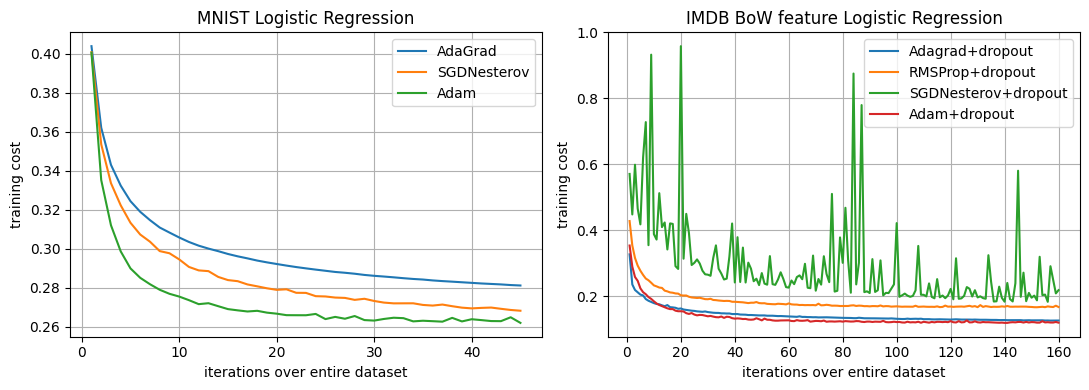

In [4]:
################ Section 6.1 Experiment Logistic Regression ################

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def loss_and_grad(params, X, y, l2_reg, activation=softmax, loss_type="nll"):
    w, b = params['w'], params['b']
    B = X.shape[0]

    logits = X @ w + b
    probs = activation(logits) # softmax / sigmoid

    if loss_type == "bce": # binary cross-entropy
        data_loss = -np.mean(y * np.log(probs + 1e-12) + (1 - y) * np.log(1 - probs + 1e-12))
    elif loss_type == "nll": # negative log-likelihood
        log_likelihood = -np.log(probs[np.arange(B), y] + 1e-12)
        data_loss = np.mean(log_likelihood)

    reg_loss = 0.5 * l2_reg * np.sum(w * w)
    loss = data_loss + reg_loss

    if loss_type == "bce":
        dlogits = (probs - y) / B
        dw = X.T @ dlogits + l2_reg * w
        db = np.sum(dlogits)
    elif loss_type == "nll":
        dscores = probs
        dscores[np.arange(B), y] -= 1.0
        dscores /= B
        dw = X.T @ dscores + l2_reg * w
        db = np.sum(dscores, axis=0)
        

    grads = {'w': dw, 'b': db}
    return loss, grads

def iterate_minibatches(X, y, batch_size, shuffle=True):
    N = X.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, N, batch_size):
        end = start + batch_size
        excerpt = indices[start:end]
        yield X[excerpt], y[excerpt]
    
# MNIST logistic regression (multiclass softmax)

def load_mnist():

    train_dataset = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )

    # train_dataset.data: (60000, 28, 28)
    X_train = train_dataset.data.view(-1, 28 * 28).numpy() / 255.0
    #print(X_train.shape)
    y_train = train_dataset.targets.numpy()

    # test_dataset.data: (10000, 28, 28)
    X_test = test_dataset.data.view(-1, 28 * 28).numpy() / 255.0
    #print(X_test.shape)
    y_test = test_dataset.targets.numpy()

    return X_train, y_train, X_test, y_test

def run_mnist_logreg(num_epochs=45, batch_size=128, l2_reg=1e-4):
    X_train, y_train, X_test, y_test = load_mnist()
    N_train, D = X_train.shape
    C = 10

    histories = {}

    optimizers_cfg = [
        ("AdaGrad",        AdaGradOptimizer,        {"alpha": 0.01}),
        ("SGDNesterov",    SGDNesterovOptimizer,    {"alpha": 0.01, "momentum": 0.9}),
        ("Adam",           AdamOptimizer,           {"alpha": 0.001}),
    ]

    for name, Opt, cfg in optimizers_cfg:
        params = {
            'w': np.zeros((D, C), dtype=np.float32),
            'b': np.zeros((C,), dtype=np.float32)
        }
        opt = Opt(params, **cfg)

        train_costs = []

        for epoch in range(1, num_epochs + 1):
            for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
                if hasattr(opt, "lookahead_params"):
                    p_for_grad = opt.lookahead_params(params)
                else:
                    p_for_grad = params
                _, grads = loss_and_grad(p_for_grad, X_batch, y_batch, l2_reg, activation=softmax, loss_type="nll")
                opt.step(params, grads)

            # cost over full training set (one point per full pass)
            cost, _ = loss_and_grad(params, X_train, y_train, l2_reg, activation=softmax, loss_type="nll")
            train_costs.append(cost)
            print(f"MNIST with {name} | Epoch {epoch} | Cost {cost:.4f}")

        histories[name] = np.array(train_costs)

    return histories

# IMDB BoW logistic regression (binary, dropout)

def load_imdb_bow(vocab_size=10000):

    TEXT = data.Field(tokenize=str.split, lower=True)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = torchtext_datasets.IMDB.splits(TEXT, LABEL, root='.data')

    TEXT.build_vocab(train_data, max_size=vocab_size - 1)
    LABEL.build_vocab(train_data)

    vocab = TEXT.vocab
    V = len(vocab)

    unk_token = getattr(vocab, "unk_token", None)
    if unk_token is not None and unk_token in vocab.stoi:
        unk_index = vocab.stoi[unk_token]
    else:
        unk_index = 0  # fallback

    def dataset_to_bow(dataset):
        N = len(dataset)
        X = np.zeros((N, V), dtype=np.float32)
        y = np.zeros((N,), dtype=np.float32)

        for i, example in enumerate(dataset.examples):
            for token in example.text:
                idx = vocab.stoi.get(token, unk_index)
                if 0 <= idx < V:
                    X[i, idx] += 1.0

            # labels: "pos" -> 1.0, "neg" -> 0.0
            y[i] = 1.0 if example.label == "pos" else 0.0

        return X, y

    X_train, y_train = dataset_to_bow(train_data)
    X_test, y_test = dataset_to_bow(test_data)

    return X_train, y_train, X_test, y_test


def run_imdb_logreg(num_epochs=160, batch_size=128, l2_reg=1e-5,
                    vocab_size=10000, dropout_rate=0.5):
    X_train, y_train, X_test, y_test = load_imdb_bow(vocab_size)
    N_train, D = X_train.shape

    histories = {}
    keep_prob = 1.0 - dropout_rate

    optimizers_cfg = [
        ("Adagrad+dropout",        AdaGradOptimizer,       {"alpha": 0.05}),
        ("RMSProp+dropout",        RMSPropOptimizer,       {"alpha": 0.001, "beta": 0.9}),
        ("SGDNesterov+dropout",    SGDNesterovOptimizer,   {"alpha": 0.01, "momentum": 0.9}),
        ("Adam+dropout",           AdamOptimizer,          {"alpha": 0.002}),
    ]

    for name, Opt, cfg in optimizers_cfg:
        params = {
            'w': np.zeros((D,), dtype=np.float32),
            'b': np.float32(0.0)
        }
        opt = Opt(params, **cfg)

        train_costs = []

        for epoch in range(1, num_epochs + 1):
            for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
                # 50% dropout noise on BoW features
                mask = (np.random.rand(*X_batch.shape) < keep_prob).astype(np.float32)
                X_drop = X_batch * mask

                if hasattr(opt, "lookahead_params"):
                    p_for_grad = opt.lookahead_params(params)
                else:
                    p_for_grad = params

                _, grads = loss_and_grad(p_for_grad, X_drop, y_batch, l2_reg, activation=sigmoid, loss_type="bce")
                opt.step(params, grads)

            cost, _ = loss_and_grad(params, X_train, y_train, l2_reg, activation=sigmoid, loss_type="bce")
            train_costs.append(cost)
            print(f"IMDB with {name} | Epoch {epoch} | Cost {cost:.4f}")

        histories[name] = np.array(train_costs)

    return histories


mnist_hist = run_mnist_logreg()
imdb_hist  = run_imdb_logreg()

# plot mnist
plt.figure(figsize=(11, 4))

ax1 = plt.subplot(1, 2, 1)
epochs_mnist = np.arange(1, len(next(iter(mnist_hist.values()))) + 1)

for name, hist in mnist_hist.items():
    ax1.plot(epochs_mnist, hist, label=name)

ax1.set_xlabel("iterations over entire dataset")
ax1.set_ylabel("training cost")
ax1.set_title("MNIST Logistic Regression")
ax1.grid(True)
ax1.legend()

# plot imdb 
ax2 = plt.subplot(1, 2, 2)
epochs_imdb = np.arange(1, len(next(iter(imdb_hist.values()))) + 1)

for name, hist in imdb_hist.items():
    ax2.plot(epochs_imdb, hist, label=name)
ax2.set_xlabel("iterations over entire dataset")
ax2.set_ylabel("training cost")
ax2.set_title("IMDB BoW feature Logistic Regression")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


AdaGrad | Epoch 1 | Cost 0.1531
AdaGrad | Epoch 2 | Cost 0.1157
AdaGrad | Epoch 3 | Cost 0.0979
AdaGrad | Epoch 4 | Cost 0.0893
AdaGrad | Epoch 5 | Cost 0.0811
AdaGrad | Epoch 6 | Cost 0.0753
AdaGrad | Epoch 7 | Cost 0.0702
AdaGrad | Epoch 8 | Cost 0.0684
AdaGrad | Epoch 9 | Cost 0.0633
AdaGrad | Epoch 10 | Cost 0.0608
AdaGrad | Epoch 11 | Cost 0.0590
AdaGrad | Epoch 12 | Cost 0.0557
AdaGrad | Epoch 13 | Cost 0.0544
AdaGrad | Epoch 14 | Cost 0.0526
AdaGrad | Epoch 15 | Cost 0.0516
AdaGrad | Epoch 16 | Cost 0.0498
AdaGrad | Epoch 17 | Cost 0.0487
AdaGrad | Epoch 18 | Cost 0.0477
AdaGrad | Epoch 19 | Cost 0.0467
AdaGrad | Epoch 20 | Cost 0.0466
AdaGrad | Epoch 21 | Cost 0.0453
AdaGrad | Epoch 22 | Cost 0.0443
AdaGrad | Epoch 23 | Cost 0.0436
AdaGrad | Epoch 24 | Cost 0.0430
AdaGrad | Epoch 25 | Cost 0.0425
AdaGrad | Epoch 26 | Cost 0.0421
AdaGrad | Epoch 27 | Cost 0.0410
AdaGrad | Epoch 28 | Cost 0.0405
AdaGrad | Epoch 29 | Cost 0.0402
AdaGrad | Epoch 30 | Cost 0.0395
AdaGrad | Epoch 31 

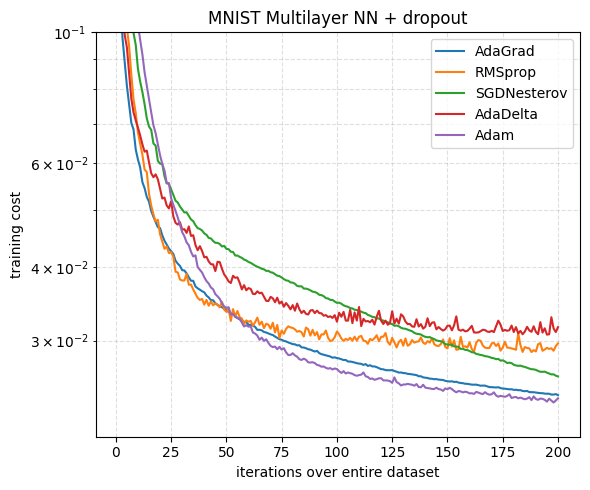

In [12]:
################ Section 6.2 Experiment Multi-Layer Neural Networks ################

batch_size   = 128
num_epochs   = 200 
weight_decay = 1e-4 
dropout_p    = 0.5  

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

full_train_loader = DataLoader(
    train_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


class MLP(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(x.size(0), -1)         # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc3(x)
        return x


def l2_penalty(model):
    l2 = 0.0
    for p in model.parameters():
        if p.requires_grad:
            l2 = l2 + torch.sum(p ** 2)
    return l2


def train_with_optimizer(optimizer_name, optimizer_ctor, opt_kwargs):

    model = MLP(dropout_p=dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()

    opt = optimizer_ctor(model.parameters(), weight_decay=0.0, **opt_kwargs)

    train_costs = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            opt.zero_grad()
            logits = model(images)
            ce_loss = criterion(logits, labels)
            l2 = l2_penalty(model)
            loss = ce_loss + 0.5 * weight_decay * l2
            loss.backward()
            opt.step()

        # compute training cost on full dataset w/o dropout
        model.eval()
        total_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for images, labels in full_train_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                logits = model(images)
                ce_loss = criterion(logits, labels)
                l2 = l2_penalty(model)
                loss = ce_loss + 0.5 * weight_decay * l2

                batch_size_curr = images.size(0)
                total_loss += loss.item() * batch_size_curr
                total_samples += batch_size_curr

        avg_loss = total_loss / total_samples
        train_costs.append(avg_loss)
        print(f"{optimizer_name} | Epoch {epoch} | Cost {avg_loss:.4f}")

    return np.array(train_costs)


# run optimizers

configs = [
    ("AdaGrad", optim.Adagrad, {"lr": 0.02}),
    ("RMSprop", optim.RMSprop, {"lr": 2e-4, "alpha": 0.9}),
    ("SGDNesterov", optim.SGD, {"lr": 0.01, "momentum": 0.9, "nesterov": True}),
    ("AdaDelta", optim.Adadelta, {"lr": 0.5, "rho": 0.95}),
    ("Adam", optim.Adam, {"lr": 8e-5}),
]
histories = {}

for name, Opt, cfg in configs:
    histories[name] = train_with_optimizer(name, Opt, cfg)

# figure 2a
plt.figure(figsize=(6, 5))
epochs = np.arange(1, num_epochs + 1)

plt.yscale("log")
for name, hist in histories.items():
    plt.plot(epochs, hist, label=name)

plt.xlabel("iterations over entire dataset")
plt.ylim(None, 0.1)
plt.ylabel("training cost")
plt.title("MNIST Multilayer NN + dropout")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


AdaGrad | Epoch 0 | Cost 2.3024
AdaGrad | Epoch 1 | Cost 1.3897
AdaGrad | Epoch 2 | Cost 1.1513
AdaGrad | Epoch 3 | Cost 1.1097
AdaGrad | Epoch 4 | Cost 0.9377
AdaGrad | Epoch 5 | Cost 0.9501
AdaGrad | Epoch 6 | Cost 0.9246
AdaGrad | Epoch 7 | Cost 0.7783
AdaGrad | Epoch 8 | Cost 0.7908
AdaGrad | Epoch 9 | Cost 0.7401
AdaGrad | Epoch 10 | Cost 0.6837
AdaGrad | Epoch 11 | Cost 0.7093
AdaGrad | Epoch 12 | Cost 0.6419
AdaGrad | Epoch 13 | Cost 0.6203
AdaGrad | Epoch 14 | Cost 0.5814
AdaGrad | Epoch 15 | Cost 0.5968
AdaGrad | Epoch 16 | Cost 0.5310
AdaGrad | Epoch 17 | Cost 0.5067
AdaGrad | Epoch 18 | Cost 0.5073
AdaGrad | Epoch 19 | Cost 0.4687
AdaGrad | Epoch 20 | Cost 0.4723
AdaGrad | Epoch 21 | Cost 0.4391
AdaGrad | Epoch 22 | Cost 0.4277
AdaGrad | Epoch 23 | Cost 0.4294
AdaGrad | Epoch 24 | Cost 0.3758
AdaGrad | Epoch 25 | Cost 0.3884
AdaGrad | Epoch 26 | Cost 0.3979
AdaGrad | Epoch 27 | Cost 0.3556
AdaGrad | Epoch 28 | Cost 0.4087
AdaGrad | Epoch 29 | Cost 0.3192
AdaGrad | Epoch 30 |

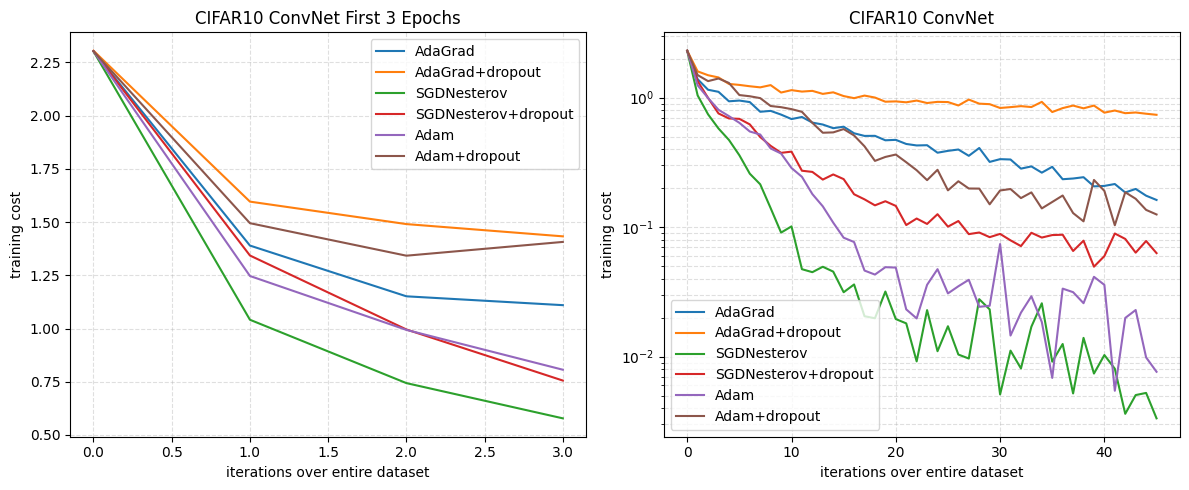

In [ ]:
################ Section 6.3 Experiment Convolutional Neural Networks ################


batch_size      = 128
num_epochs_full = 45       
dropout_input_p = 0.2      # dropout on input
dropout_fc_p    = 0.5      # dropout on FC

# https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

# For computing full training cost
train_loader_full = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_classes = 10

class CifarConvNet(nn.Module):
    def __init__(self, use_dropout: bool):
        super().__init__()
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(3,   128, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.pool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # After 3 pools: 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc1   = nn.Linear(256 * 4 * 4, 1000)
        self.fc2   = nn.Linear(1000, num_classes)

    def forward(self, x):
        # Input dropout
        if self.training and self.use_dropout and dropout_input_p > 0.0:
            x = F.dropout(x, p=dropout_input_p, training=True)

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        # FC dropout
        if self.training and self.use_dropout and dropout_fc_p > 0.0:
            x = F.dropout(x, p=dropout_fc_p, training=True)

        x = self.fc2(x)
        return x


def l2_penalty(model):
    l2 = 0.0
    for p in model.parameters():
        if p.requires_grad:
            l2 = l2 + torch.sum(p ** 2)
    return l2


def compute_training_cost(model, criterion): # (cross entropy)
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for images, labels in train_loader_full:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            logits = model(images)
            ce_loss = criterion(logits, labels)
            loss = ce_loss
            bs = images.size(0)
            total_loss += loss.item() * bs
            total_samples += bs
    return total_loss / total_samples


def train_cnn(name, Opt, use_dropout, **optimizer_cfg):
    model = CifarConvNet(use_dropout=use_dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Opt(model.parameters(), **optimizer_cfg)

    costs = []

    # cost at epoch 0 (untrained)
    cost0 = compute_training_cost(model, criterion)
    costs.append(cost0)
    print(f"{name} | Epoch 0 | Cost {cost0:.4f}")

    for epoch in range(1, num_epochs_full + 1):
        model.train()
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(images)
            ce_loss = criterion(logits, labels)
            loss = ce_loss
            loss.backward()
            optimizer.step()

        cost = compute_training_cost(model, criterion)
        costs.append(cost)
        print(f"{name} | Epoch {epoch} | Cost {cost:.4f}")

    return np.array(costs)


histories = {}
configs = [
    ("AdaGrad", optim.Adagrad, False, {"lr": 0.01}),
    ("AdaGrad+dropout", optim.Adagrad, True, {"lr": 0.01}),
    ("SGDNesterov", optim.SGD, False, {"lr": 0.01, "momentum": 0.9, "nesterov": True}),
    ("SGDNesterov+dropout", optim.SGD, True, {"lr": 0.01, "momentum": 0.9, "nesterov": True}),
    ("Adam", optim.Adam, False, {"lr": 0.0001}),
    ("Adam+dropout", optim.Adam, True, {"lr": 0.0001}),
]

for name, Opt, use_dropout, cfg in configs:
    histories[name] = train_cnn(name, Opt, use_dropout, **cfg)


# ---------------------------------------------------------
# Plot: CIFAR10 ConvNet First 3 Epochs (linear scale)
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
epochs_3 = np.arange(0, 3 + 1)   # 0,1,2,3
for k,v in histories.items():
    ax1.plot(epochs_3, v[:4], label=k)
ax1.set_xlabel("iterations over entire dataset")
ax1.set_ylabel("training cost")
ax1.set_title("CIFAR10 ConvNet First 3 Epochs")
ax1.grid(True, ls="--", alpha=0.4)
ax1.legend()

# ---------------------------------------------------------
# Plot: CIFAR10 ConvNet 45 epochs (log scale)
# ---------------------------------------------------------
ax2 = plt.subplot(1, 2, 2)
epochs_full = np.arange(0, num_epochs_full + 1)
ax2.set_yscale("log")
for k,v in histories.items():
    ax2.plot(epochs_full, v, label=k)
ax2.set_xlabel("iterations over entire dataset")
ax2.set_ylabel("training cost")
ax2.set_title("CIFAR10 ConvNet")
ax2.grid(True, which="both", ls="--", alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()


beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=1, loss=368.51
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=2, loss=230.60
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=3, loss=207.01
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=4, loss=199.51
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=5, loss=194.62
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=6, loss=189.46
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=7, loss=183.93
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=8, loss=179.12
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=9, loss=174.82
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=10, loss=171.06
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=11, loss=168.11
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=12, loss=165.82
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=13, loss=164.13
beta1=0.0, beta2=0.99, lr=1.0e-05, bias_corr=True, epoch=14,

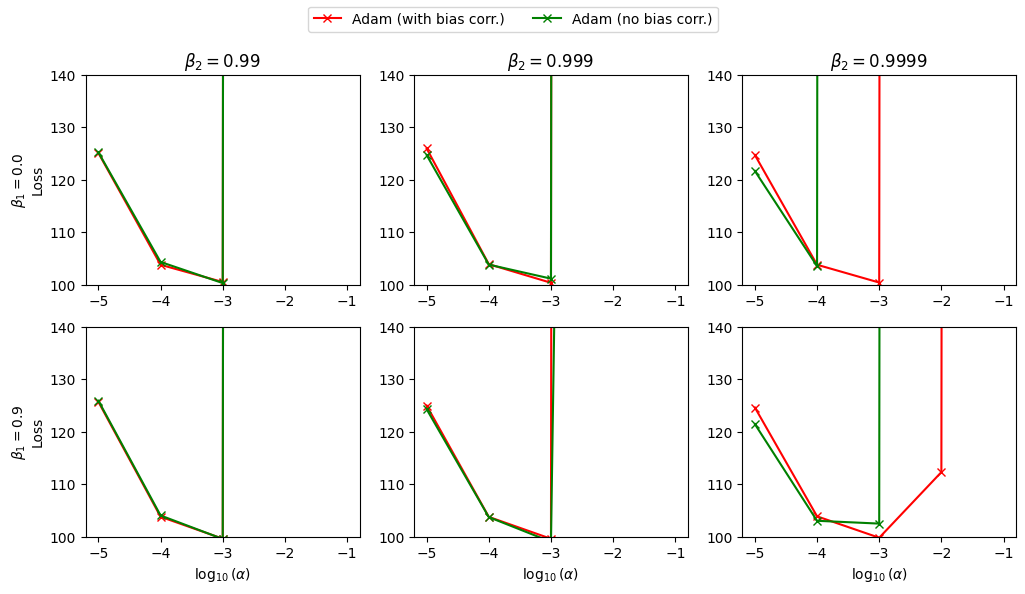

In [ ]:
################ Section 6.4 Bias Correction Term ################

class VAE(nn.Module):
    # 1 hidden layer of 500 units with softplus, latent dimension 50
    def __init__(self, input_dim=28*28, h_dim=500, z_dim=50):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)  # mu
        self.fc22 = nn.Linear(h_dim, z_dim)  # logvar
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h1 = F.softplus(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.softplus(self.fc3(z))
        return self.fc4(h3)  # logits for Bernoulli

    def forward(self, x):
        # x: (batch, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_logits = self.decode(z)
        return recon_logits, mu, logvar


def elbo_loss(recon_logits, x, mu, logvar, reduction="sum"):
    recon_loss = F.binary_cross_entropy_with_logits(
        recon_logits, x, reduction=reduction
    )
    logvar_clamped = torch.clamp(logvar, min=-30.0, max=20.0)  # reasonable bounds
    var = torch.exp(logvar_clamped)
    kld = -0.5 * torch.sum(1 + logvar_clamped - mu.pow(2) - var)
    loss = recon_loss + kld
    # replace non-finite values with a large constant
    finite_mask = torch.isfinite(loss)
    loss = torch.where(finite_mask, loss, torch.full_like(loss, 999999.0))
    return loss


class AdamWithOptionalBiasCorrection(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999),
                 eps=1e-8, weight_decay=0, bias_correction=True):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay,
                        bias_correction=bias_correction)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            do_bc = group['bias_correction']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad

                if weight_decay != 0:
                    grad = grad.add(p, alpha=weight_decay)

                state = self.state[p]

                # state init
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                state['step'] += 1
                t = state['step']

                # moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                if do_bc:
                    # normal Adam
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    step_size = lr / bias_correction1
                    denom = (exp_avg_sq / bias_correction2).sqrt().add_(eps)
                else:
                    # without bias correction:RMSProp 
                    step_size = lr
                    denom = exp_avg_sq.sqrt().add_(eps)

                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss





def train_vae_for_config(beta1, beta2, lr, num_epochs, bias_correction=True, batch_size=100 ):
    transform = transforms.ToTensor()
    train_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )

    model = VAE().to(device)
    optimizer = AdamWithOptionalBiasCorrection(
        model.parameters(),
        lr=lr,
        betas=(beta1, beta2),
        bias_correction=bias_correction
    )

    epoch_losses = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        num_samples = 0

        for x, _ in train_loader:
            x = x.view(x.size(0), -1).to(device)
            optimizer.zero_grad()
            recon_logits, mu, logvar = model(x)
            loss = elbo_loss(recon_logits, x, mu, logvar, reduction="sum")
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_samples += x.size(0)

        avg_loss = total_loss / num_samples
        epoch_losses.append(avg_loss)
        print(
            f"beta1={beta1}, beta2={beta2}, lr={lr:.1e}, "
            f"bias_corr={bias_correction}, epoch={epoch}, loss={avg_loss:.2f}"
        )

    return epoch_losses



def run_experiment(betas1=(0.0, 0.9),
                   betas2=(0.99, 0.999, 0.9999),
                   log10_alphas=(-5, -4, -3, -2, -1),
                   num_epochs=100,
                   batch_size=100):

    alphas = [10.0 ** a for a in log10_alphas]

    # results[(beta1, beta2)] = {"with": [losses over alphas], "without": [losses over alphas]}
    results = defaultdict(lambda: {"with": [], "without": []})

    for beta1 in betas1:
        for beta2 in betas2:
            for lr in alphas:
                # with bias correction (Adam)
                losses_with = train_vae_for_config(
                    beta1, beta2, lr,
                    num_epochs=num_epochs,
                    bias_correction=True,
                    batch_size=batch_size,
                )
                # without bias correction (RMSProp + momentum)
                losses_without = train_vae_for_config(
                    beta1, beta2, lr,
                    num_epochs=num_epochs,
                    bias_correction=False,
                    batch_size=batch_size,
                )

                key = (beta1, beta2)

                # use the supplied number of epochs -> final epoch loss
                results[key]["with"].append(losses_with[-1])
                results[key]["without"].append(losses_without[-1])

    return results, list(betas1), list(betas2), list(log10_alphas)



def plot_results(results, betas1, betas2, log10_alphas):
    fig, axes = plt.subplots(
        nrows=len(betas1),
        ncols=len(betas2),
        figsize=(12, 6),
    )

    for row, beta1 in enumerate(betas1):
        for col, beta2 in enumerate(betas2):
            ax = axes[row, col]
            key = (beta1, beta2)
            y_with = results[key]["with"]      # list over alphas
            y_without = results[key]["without"]

            ax.plot(log10_alphas, y_with, "r-x", label="with bias corr.")
            ax.plot(log10_alphas, y_without, "g-x", label="no bias corr.")
            ax.set_xticks(log10_alphas)
            ax.set_ylim(100,140)

            if row == 0:
                ax.set_title(rf"$\beta_2={beta2}$")
            if col == 0:
                ax.set_ylabel(rf"$\beta_1={beta1}$" + "\nLoss")

    for ax in axes[-1, :]:
        ax.set_xlabel(r"$\log_{10}(\alpha)$")

    # Global legend: shared for all subplots
    red_line = Line2D([0], [0], linestyle="-", marker="x", color="r",
                      label="Adam (with bias corr.)")
    green_line = Line2D([0], [0], linestyle="-", marker="x", color="g",
                        label="Adam (no bias corr.)")
    fig.legend(handles=[red_line, green_line],
               loc="upper center", ncol=2)

    plt.savefig("adam_bias_correction_vae.png")



# expensive to run all: 2 (beta1) * 3 (beta2) * 5 (alphas) * 2 (with/without) * 100 epochs.
results, betas1, betas2, log10_alphas = run_experiment(
    betas1=(0.0, 0.9),
    betas2=(0.99, 0.999, 0.9999),
    log10_alphas=(-5, -4, -3, -2, -1),
    num_epochs=100,
    batch_size=100,
)

plot_results(results, betas1, betas2, log10_alphas)
